In [29]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting retail demand with Vertex AI and BigQuery ML 

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/demand_forecasting/forecasting-retail-demand.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fvertex-ai-samples%2Fmain%2Fnotebooks%2Fofficial%2Fworkbench%2Fdemand_forecasting%2Fforecasting-retail-demand.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-enterprise-logo-32px.png" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/demand_forecasting/forecasting-retail-demand.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
  <td style="text-align: center">
<a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/workbench/demand_forecasting/forecasting-retail-demand.ipynb" target='_blank'>
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
     </a>
   </td>
</table>
<br/><br/><br/>

## Overview 

This tutorial explores demand forecasting using a BigQuery public retail dataset. Being able to measure and forecast customer demand can help retailers better understand their customers, stock shelves with the right products, offer targeted promotions, and generally, better plan and manage their budgets. This notebook applies an ARIMA (Autoregressive integrated moving average) model from BigQuery ML on retail data. This notebook demonstrates how to train and evaluate a BigQuery ML model for demand forecasting datasets and extract actionable future insights.

*Note: This notebook file was designed to run in a [Vertex AI Workbench managed notebooks](https://cloud.google.com/vertex-ai/docs/workbench/managed/create-instance) instance using the `Python (Local)` kernel. Some components of this notebook may not work in other notebook environments.*

#### ARIMA Modeling with BigQuery ML 

The <a href='https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average'>ARIMA model</a> is designed to analyze historical data, spot patterns over time, and project them into the future in other words, forecasting. The model is available inside BigQuery ML and enables users to create and execute machine learning models directly in BigQuery using SQL queries. Working with BigQuery ML is advantageous, as it already has access to the data, it can handle most of the modeling details automatically if desired, and stores both the model and any predictions also inside BigQuery. 

Learn more about [Vertex AI Workbench](https://cloud.google.com/vertex-ai/docs/workbench/introduction) and [BigQuery ML](https://cloud.google.com/bigquery-ml/docs/managing-models-vertex).

### Objective
In this tutorial, you learn how to build ARIMA (Autoregressive integrated moving average) model from BigQuery ML on retail data

This tutorial uses the following Google Cloud ML services:
- BigQuery

The steps performed include:

* Explore data
* Model with BigQuery and the ARIMA model
* Evaluate the model
* Evaluate the model results using BigQuery ML (on training data)
* Evaluate the model results - MAE, MAPE, MSE, RMSE (on test data)
* Use the executor feature

### Dataset 

This notebook uses the BigQuery public retail dataset.
The data covers 10 US stores and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price and gross margin. 

### Costs
This tutorial uses the following billable components of Google Cloud:

* Vertex AI
* BigQuery

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing), 
[BigQuery pricing](https://cloud.google.com/bigquery/pricing) and use the 
[Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Install additional packages


In [1]:
! pip3 install --quiet --upgrade pandas-gbq 'google-cloud-bigquery[bqstorage,pandas]' \
                                 scikit-learn \
                                 matplotlib


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### Restart runtime (Colab only)
To use the newly installed packages, you must restart the runtime on Google Colab.

In [31]:
import sys

if "google.colab" in sys.modules:

    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">,
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>,
</div>

### Authenticate your notebook environment (Colab only)
Authenticate your environment on Google Colab.

In [32]:
import sys

if "google.colab" in sys.modules:

    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information
Learn more about [setting up a project and a development environment.](https://cloud.google.com/vertex-ai/docs/start/cloud-environment)

In [2]:
PROJECT_ID = "<your_project_id>"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

### Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.

In [3]:
BUCKET_URI = f"gs://<your_bucket_name>"  # @param {type:"string"}

**If your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $LOCATION $BUCKET_URI

## Import libraries and define constants

**Load the required libraries.**

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import bigquery
from google.cloud.bigquery import Client
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error,
                             root_mean_squared_error)

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

**Set the name for the table**

In [5]:
SALES_TABLE = "training_data_table"

# Construct a BigQuery client object.

client = Client(project=PROJECT_ID)

**Create a BigQuery datatset**

In [7]:
dataset_id = "demandforecasting" + "_" + "unique"

If you're using ***Vertex AI Workbench managed notebooks instance***, Identify cells starting with "#@bigquery" as SQL queries. If you're using [Vertex AI Workbench user managed notebooks instance](https://cloud.google.com/vertex-ai/docs/workbench/user-managed/migrate-to-instances) or Colab it will be a markdown cell.

#@bigquery
CREATE SCHEMA demandforecasting_unique
OPTIONS(
  location="us"
  )

(**Optional**) If you're using Vertex AI Workbench managed notebooks instance, once the results from BigQuery are displayed in the below cell, click the **Query and load as DataFrame** button and execute the generated code stub to fetch the data into the current notebook as a dataframe.

*Note: By default the data is loaded into a `df` variable, though this can be changed before executing the cell if required.*

In [ ]:
query = """
CREATE SCHEMA `{PROJECT_ID}.{dataset_id}`
OPTIONS(
  location="us"
  )
""".format(
    PROJECT_ID=PROJECT_ID, dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

## Explore the Data
View the data that is stored in the public BigQuery dataset.

#@bigquery
SELECT * FROM `looker-private-demo.retail.transaction_detail`

In [9]:
query = """
SELECT * FROM `looker-private-demo.retail.transaction_detail`
"""
query_job = client.query(query)

In [ ]:
query_job.to_dataframe()

**Create a view named `important_fields` using only the `transaction_timestamp` and `line_items` fields, where the store ID is 10.**

#@bigquery
CREATE OR REPLACE VIEW demandforecasting_unique.important_fields AS
(
    SELECT transaction_timestamp,line_items from `looker-private-demo.retail.transaction_detail` WHERE store_id = 10
)   

In [ ]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.important_fields AS
(
    SELECT transaction_timestamp,line_items from `looker-private-demo.retail.transaction_detail` WHERE store_id = 10
)   
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

**Look at the data in the `important_fields` view.**

#@bigquery
SELECT * FROM demandforecasting_unique.important_fields

In [ ]:
query = """
SELECT * FROM {dataset_id}.important_fields
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

**Convert the `transaction_timestamp` field into a date.**

#@bigquery
CREATE OR REPLACE VIEW demandforecasting_unique.data_after_converting_timestamp_to_date AS
(
    SELECT EXTRACT(DATE FROM transaction_timestamp AT TIME ZONE "UTC") AS date,line_items from demandforecasting_unique.important_fields
)   

In [ ]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.data_after_converting_timestamp_to_date AS
(
    SELECT EXTRACT(DATE FROM transaction_timestamp AT TIME ZONE "UTC") AS date,line_items from {dataset_id}.important_fields
)   
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

**View the data and check the `date` field values.**

#@bigquery
SELECT * FROM demandforecasting_unique.data_after_converting_timestamp_to_date

In [40]:
query = """
SELECT * FROM {dataset_id}.data_after_converting_timestamp_to_date
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,date,line_items
0,2022-11-06,"[{'product_id': 4271, 'sale_price': 39.9900016..."
1,2022-11-06,"[{'product_id': 18144, 'sale_price': 71.800003..."
2,2022-11-06,"[{'product_id': 20552, 'sale_price': 64.0, 'gr..."
3,2022-11-06,"[{'product_id': 2451, 'sale_price': 68.0, 'gro..."
4,2022-11-06,"[{'product_id': 8263, 'sale_price': 60.0, 'gro..."
...,...,...
29707,2023-08-08,"[{'product_id': 22699, 'sale_price': 54.0, 'gr..."
29708,2023-08-08,"[{'product_id': 6467, 'sale_price': 25.0, 'gro..."
29709,2023-08-08,"[{'product_id': 21656, 'sale_price': 39.990001..."
29710,2023-08-08,"[{'product_id': 162, 'sale_price': 34.99000167..."


**Load the data into a dataframe.**

In [41]:
df_intermediary = query_job.to_dataframe()

**Check the data types of your dataframe fields.**

In [42]:
df_intermediary.dtypes

date          dbdate
line_items    object
dtype: object

The `line_items` field is an array of structs. Split the array into its component parts, `product_id`, `sale_price`, and `gross_margin`.

#@bigquery
CREATE OR REPLACE VIEW demandforecasting_unique.split_array_of_structs AS
 
(SELECT date,line_items
FROM demandforecasting_unique.data_after_converting_timestamp_to_date, UNNEST(line_items) AS line_items)

In [ ]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.split_array_of_structs AS
 
(SELECT date,line_items
FROM {dataset_id}.data_after_converting_timestamp_to_date, UNNEST(line_items) AS line_items)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

**View the data.**

#@bigquery
SELECT * FROM demandforecasting_unique.split_array_of_structs

In [ ]:
query = """
SELECT * FROM {dataset_id}.split_array_of_structs
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

**Remove the extra columns to keep only `date` and `product_id`.**

#@bigquery
CREATE OR REPLACE VIEW demandforecasting_unique.splitting_struct_columns AS
 
(SELECT date,line_items.product_id as product_id
FROM demandforecasting_unique.split_array_of_structs)

In [ ]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.splitting_struct_columns AS
 
(SELECT date,line_items.product_id as product_id
FROM {dataset_id}.split_array_of_structs)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

**View the data.**

#@bigquery
SELECT * FROM demandforecasting_unique.splitting_struct_columns 

In [ ]:
query = """
SELECT * FROM {dataset_id}.splitting_struct_columns 
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

**Count the sales of a product for each date.**

#@bigquery
CREATE OR REPLACE VIEW demandforecasting_unique.sales_count_per_date AS
 
(SELECT date,product_id,COUNT(*) as sales_count
FROM demandforecasting_unique.splitting_struct_columns GROUP BY date,product_id)

In [ ]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.sales_count_per_date AS
 
(SELECT date,product_id,COUNT(*) as sales_count
FROM {dataset_id}.splitting_struct_columns GROUP BY date,product_id)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

#@bigquery
SELECT * FROM demandforecasting_unique.sales_count_per_date

In [ ]:
query = """
SELECT * FROM {dataset_id}.sales_count_per_date
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

**Create a view for the five products that have sold the most units over the entire date range.**

#@bigquery
CREATE OR REPLACE VIEW demandforecasting_unique.top_five_products AS (
    WITH topsellingitems AS(
         SELECT 
            product_id,
            sum(sales_count) sum_sales
        FROM
            `demandforecasting_unique.sales_count_per_date` 
        GROUP BY 
            product_id
        ORDER BY sum_sales DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        product_id,
        sales_count
    FROM
        `demandforecasting_unique.sales_count_per_date` 
    WHERE
        product_id IN (SELECT product_id FROM topsellingitems)
    )

In [ ]:
query = """
CREATE OR REPLACE VIEW {dataset_id}.top_five_products AS (
    WITH topsellingitems AS(
         SELECT 
            product_id,
            sum(sales_count) sum_sales
        FROM
            `{dataset_id}.sales_count_per_date` 
        GROUP BY 
            product_id
        ORDER BY sum_sales DESC
        LIMIT 5 #Top N
    )
    SELECT 
        date,
        product_id,
        sales_count
    FROM
        `{dataset_id}.sales_count_per_date` 
    WHERE
        product_id IN (SELECT product_id FROM topsellingitems)
    )
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)
print(query_job.result())

#@bigquery
SELECT * FROM demandforecasting_unique.top_five_products


In [48]:
query = """
SELECT * FROM {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

query_job.to_dataframe()

,date,product_id,sales_count
0,2023-07-10,23641,1
1,2022-04-09,20547,1
2,2024-10-12,23641,1
3,2023-02-17,28305,1
4,2022-10-10,20552,1
...,...,...,...
2486,2022-08-22,28305,2
2487,2022-12-13,28305,1
2488,2020-12-09,13596,1
2489,2023-04-26,23641,1


**Load the data into a dataframe and view the data.**

In [49]:
df = query_job.to_dataframe()
print(df)

            date  product_id  sales_count
0     2023-07-10       23641            1
1     2022-04-09       20547            1
2     2024-10-12       23641            1
3     2023-02-17       28305            1
4     2022-10-10       20552            1
...          ...         ...          ...
2486  2022-08-22       28305            2
2487  2022-12-13       28305            1
2488  2020-12-09       13596            1
2489  2023-04-26       23641            1
2490  2022-05-25       23641            1

[2491 rows x 3 columns]


**Check the data types of your dataframe fields.**

In [50]:
df.dtypes

date           dbdate
product_id      Int64
sales_count     Int64
dtype: object

**Convert the `date` field's data type to `datetime`.**

In [51]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

For this forecasting model, date values need to present for all dates, for each product.

To construct a dataframe with `0` values for the `sales_count` field, on dates in which products weren't sold, determine the minimum and maximum dates so that you know which dates need `0` values.

**First, get the earliest (minimum) date.**

#@bigquery
SELECT MIN(DATE) AS min_date FROM demandforecasting_unique.top_five_products

In [52]:
query = """
SELECT MIN(DATE) AS min_date FROM {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)


MIN_DATE=pd.to_datetime(query_job.to_dataframe()['min_date']).astype(str).values[0]
MIN_DATE

'2020-05-21'

**Get the latest (maximum) date.**

#@bigquery
SELECT MAX(DATE) AS max_date FROM demandforecasting_unique.top_five_products 

In [53]:
query = """
SELECT MAX(DATE) as max_date FROM {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

MAX_DATE=pd.to_datetime(query_job.to_dataframe()['max_date']).astype(str).values[0]
MAX_DATE


'2025-03-11'

**Add the full date range of values to a dataframe.**

In [43]:
dates = pd.date_range(start=MIN_DATE, end=MAX_DATE).to_frame()

**Get a description of the `dates` dataframe.**

In [56]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1756 entries, 2020-05-21 to 2025-03-11
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   0       1756 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 27.4 KB


**View the data for one of the products, sorted by date, to show that many dates are'nt present in the dataset.**

In [57]:
df.loc[df["product_id"] == 20552].sort_values(by=["date"])

,date,product_id,sales_count
2253,2020-05-21,20552,1
1993,2020-06-07,20552,2
943,2020-06-27,20552,1
1664,2020-07-15,20552,1
640,2020-07-22,20552,1
...,...,...,...
2095,2025-03-03,20552,1
890,2025-03-04,20552,4
1349,2025-03-06,20552,2
612,2025-03-10,20552,1


To make a dataframe in which each product has zero missing dates, merge each of the five products' data with the `dates` dataframe.

Start with `product_id` `20552`.

In [62]:
df1 = (
    pd.merge(
        df.loc[df["product_id"] == 20552],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df1["product_id"] = 20552  # Set the product ID to the specified values.
df1.reset_index(inplace=True, drop=True)  # making index to start from 0
df1 = df1.fillna(0)  # for sales_count making null values as 0
df1["sales_count"] = df1["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print("data after converting for a product with product_id 20552")
print(df1)

df2 = (
    pd.merge(
        df.loc[df["product_id"] == 13596],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df2["product_id"] = 13596  # Set the product ID to the specified values.
df2.reset_index(inplace=True, drop=True)  # making index to start from 0
df2 = df2.fillna(0)  # for sales_count making null values as 0
df2["sales_count"] = df2["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df2)

df3 = (
    pd.merge(
        df.loc[df["product_id"] == 23641],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df3["product_id"] = 23641  # Set the product ID to the specified values.
df3.reset_index(inplace=True, drop=True)  # making index to start from 0
df3 = df3.fillna(0)  # for sales_count making null values as 0
df3["sales_count"] = df3["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df3)

df4 = (
    pd.merge(
        df.loc[df["product_id"] == 28305],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df4["product_id"] = 28305  # Set the product ID to the specified values.
df4.reset_index(inplace=True, drop=True)  # making index to start from 0
df4 = df4.fillna(0)  # for sales_count making null values as 0
df4["sales_count"] = df4["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df4)

df5 = (
    pd.merge(
        df.loc[df["product_id"] == 20547],
        dates,
        left_on="date",
        right_on=0,
        how="outer",
    )
    .sort_values(by=["date"])
    .drop(columns=0)
)  # merging dates dataframe with product_id matching rows
df5["product_id"] = 20547  # Set the product ID to the specified values.
df5.reset_index(inplace=True, drop=True)  # making index to start from 0
df5 = df5.fillna(0)  # for sales_count making null values as 0
df5["sales_count"] = df5["sales_count"].astype(
    "int"
)  # convert sales_count column to integer
print(df5)

data after converting for a product with product_id 20552
           date  product_id  sales_count
0    2020-05-21       20552            1
1    2020-05-22       20552            0
2    2020-05-23       20552            0
3    2020-05-24       20552            0
4    2020-05-25       20552            0
...         ...         ...          ...
1751 2025-03-07       20552            0
1752 2025-03-08       20552            0
1753 2025-03-09       20552            0
1754 2025-03-10       20552            1
1755 2025-03-11       20552            1

[1756 rows x 3 columns]
           date  product_id  sales_count
0    2020-05-21       13596            0
1    2020-05-22       13596            0
2    2020-05-23       13596            0
3    2020-05-24       13596            0
4    2020-05-25       13596            0
...         ...         ...          ...
1751 2025-03-07       13596            1
1752 2025-03-08       13596            1
1753 2025-03-09       13596            1
1754 2025-03-10

**Merge all five dataframes into one new dataframe.**

In [63]:
pdList = [df1, df2, df3, df4, df5]  # List of your dataframes
new_df = pd.concat(pdList)
new_df

,date,product_id,sales_count
0,2020-05-21,20552,1
1,2020-05-22,20552,0
2,2020-05-23,20552,0
3,2020-05-24,20552,0
4,2020-05-25,20552,0
...,...,...,...
1751,2025-03-07,20547,2
1752,2025-03-08,20547,0
1753,2025-03-09,20547,0
1754,2025-03-10,20547,1


**Reset the index of the dataframe.**

In [64]:
new_df.reset_index(inplace=True, drop=True)
print(new_df)

           date  product_id  sales_count
0    2020-05-21       20552            1
1    2020-05-22       20552            0
2    2020-05-23       20552            0
3    2020-05-24       20552            0
4    2020-05-25       20552            0
...         ...         ...          ...
8775 2025-03-07       20547            2
8776 2025-03-08       20547            0
8777 2025-03-09       20547            0
8778 2025-03-10       20547            1
8779 2025-03-11       20547            0

[8780 rows x 3 columns]


**View the five product IDs.**

#@bigquery
SELECT DISTINCT product_id from demandforecasting_unique.top_five_products

In [53]:
query = """
SELECT DISTINCT product_id from {dataset_id}.top_five_products
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

In [54]:
query_job.to_dataframe()

,product_id
0,20547
1,13596
2,23641
3,20552
4,28305


**Plot `sales_count` over time, for each product.**

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

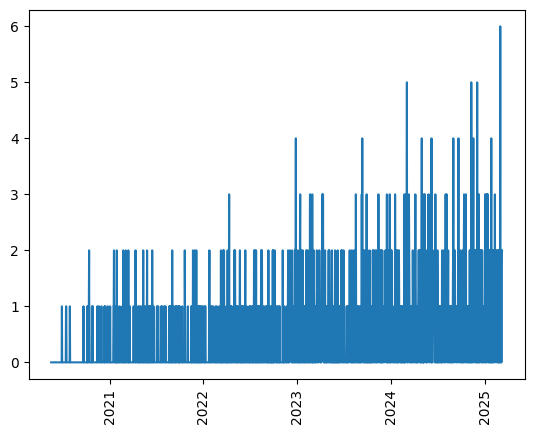

In [55]:
plt.plot(
    new_df.loc[new_df["product_id"] == 20552]["date"],
    new_df.loc[new_df["product_id"] == 20552]["sales_count"],
)
plt.xticks(rotation="vertical")

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

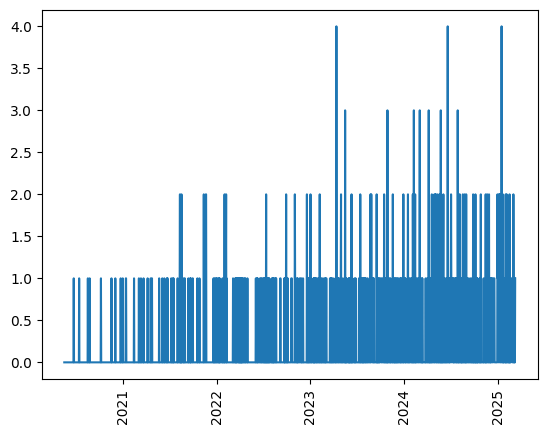

In [56]:
plt.plot(
    new_df.loc[new_df["product_id"] == 20547]["date"],
    new_df.loc[new_df["product_id"] == 20547]["sales_count"],
)
plt.xticks(rotation="vertical")

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

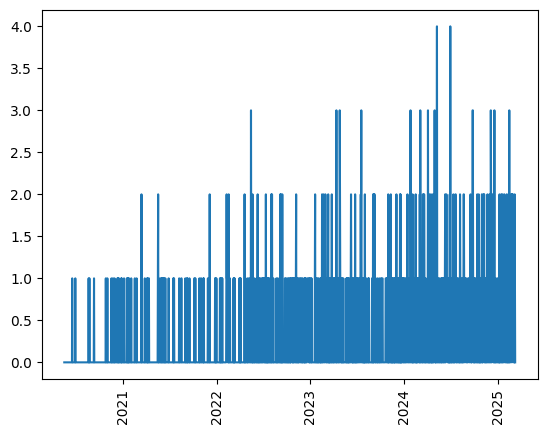

In [57]:
plt.plot(
    new_df.loc[new_df["product_id"] == 28305]["date"],
    new_df.loc[new_df["product_id"] == 28305]["sales_count"],
)
plt.xticks(rotation="vertical")

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

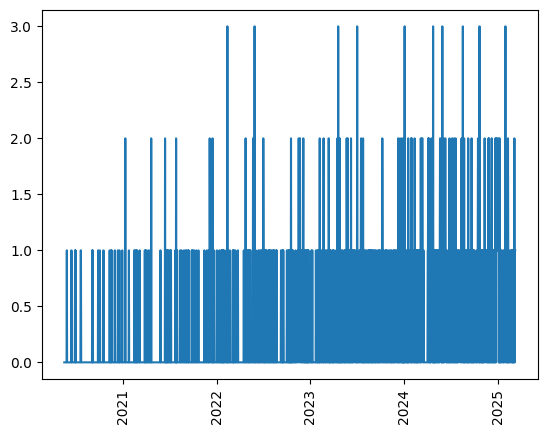

In [58]:
plt.plot(
    new_df.loc[new_df["product_id"] == 23641]["date"],
    new_df.loc[new_df["product_id"] == 23641]["sales_count"],
)
plt.xticks(rotation="vertical")

(array([18262., 18628., 18993., 19358., 19723., 20089.]),
 [Text(18262.0, 0, '2020'),
  Text(18628.0, 0, '2021'),
  Text(18993.0, 0, '2022'),
  Text(19358.0, 0, '2023'),
  Text(19723.0, 0, '2024'),
  Text(20089.0, 0, '2025')])

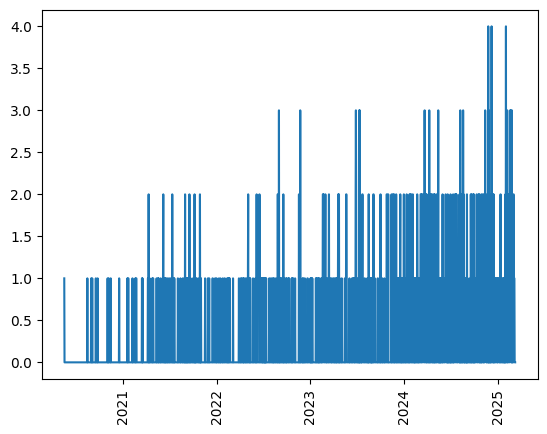

In [59]:
plt.plot(
    new_df.loc[new_df["product_id"] == 13596]["date"],
    new_df.loc[new_df["product_id"] == 13596]["sales_count"],
)
plt.xticks(rotation="vertical")

**List the data types for the `new_df` dataframe.**

In [60]:
new_df.dtypes

date           datetime64[ns]
product_id              int64
sales_count             int64
dtype: object

**Create a new BigQuery table out of the `new_df` dataframe.**

In [61]:
job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        bigquery.SchemaField("product_id", bigquery.enums.SqlTypeNames.INTEGER),
        bigquery.SchemaField("date", bigquery.enums.SqlTypeNames.DATE),
        bigquery.SchemaField("sales_count", bigquery.enums.SqlTypeNames.INTEGER),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

# save the dataframe to a table in the created dataset
job = client.load_table_from_dataframe(
    new_df,
    "{}.{}.{}".format(PROJECT_ID, dataset_id, SALES_TABLE),
    job_config=job_config,
)  # Make an API request.
job.result()  # Wait for the job to complete.

LoadJob<project=ericdjatsa-genai-demos, location=US, id=1615c7fa-e9ca-48c7-a6fe-f78a68da37a8>

In [81]:
# select the date-range and item-id(top 5) for training-data and create a table for the same
from datetime import datetime
from dateutil.relativedelta import relativedelta
TRAININGDATA_STARTDATE = MIN_DATE

#Compute training end date as 6 months back from MAX_DATE
TRAININGDATA_ENDDATE = datetime.strptime(MAX_DATE, '%Y-%m-%d').date() + relativedelta(months=-6)
print("TRAININGDATA_STARTDATE: ", TRAININGDATA_STARTDATE, ", TRAININGDATA_ENDDATE: ", TRAININGDATA_ENDDATE, ", MAX_DATE: ", MAX_DATE)

TRAININGDATA_STARTDATE:  2020-05-21 , TRAININGDATA_ENDDATE:  2024-09-11 , MAX_DATE:  2025-03-11


**Create a training dataset by setting a date range that limits the data being used.**

In [82]:
query = """
CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET}.training_data AS (
    SELECT
        *
    FROM
        `{DATASET}.{SALES_TABLE}`
    WHERE
        date BETWEEN '{STARTDATE}' AND '{ENDDATE}'
        );
""".format(
    STARTDATE=TRAININGDATA_STARTDATE,
    ENDDATE=TRAININGDATA_ENDDATE,
    DATASET=dataset_id,
    SALES_TABLE=SALES_TABLE,
    PROJECT_ID=PROJECT_ID,
)
# execute the query (as it's a create query, there won't be any tabular output)
query_job = client.query(query)
print(query_job.result())

**Select the original data for plotting.**

In [83]:
df_historical = new_df[
    (new_df["date"] >= pd.to_datetime(TRAININGDATA_STARTDATE))
    & (new_df["date"] <= pd.to_datetime(TRAININGDATA_ENDDATE))
].copy()
df_historical

,date,product_id,sales_count
0,2020-05-21,20552,1
1,2020-05-22,20552,0
2,2020-05-23,20552,0
3,2020-05-24,20552,0
4,2020-05-25,20552,0
...,...,...,...
8594,2024-09-07,20547,1
8595,2024-09-08,20547,2
8596,2024-09-09,20547,1
8597,2024-09-10,20547,0


## Modeling with BigQuery and the ARIMA model

**Create an ARIMA model using the training data.**

#@bigquery
CREATE OR REPLACE MODEL demandforecasting_unique.arima_plus_model

OPTIONS(
  MODEL_TYPE='ARIMA_PLUS',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='sales_count',
  TIME_SERIES_ID_COL='product_id',
  HOLIDAY_REGION='US'
) AS

SELECT 
    date,
    product_id,
    sales_count
FROM
  demandforecasting_unique.training_data

**Train the ARIMA model.**

In [ ]:
# Train an ARIMA model on the created dataset
query = """
CREATE OR REPLACE MODEL `{PROJECT_ID}.{DATASET}.arima_plus_model`

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date',
  TIME_SERIES_DATA_COL='sales_count',
  TIME_SERIES_ID_COL='product_id') AS

SELECT
    date,
    product_id,
    sales_count
FROM
  `{DATASET}.training_data`
""".format(
    PROJECT_ID=PROJECT_ID, DATASET=dataset_id
)
# execute the query
job = client.query(query)
job.result()

# Evaluate the model

To evaluate the trained model, get forecasts for the 90 days after the last date of the training data. In BigQuery ML, provide the number of forecast days using the `HORIZON` argument. Specify the confidence interval for the forecast using the `CONFIDENCE_LEVEL` argument.

#@bigquery dfforecast 

DECLARE HORIZON STRING DEFAULT "90";
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";

EXECUTE IMMEDIATE format('''
    SELECT
      *
    FROM
      ML.FORECAST(MODEL demandforecasting_unique.arima_plus_model,
                  STRUCT(%s AS horizon,
                         %s AS confidence_level)
                 )
    ''',HORIZON,CONFIDENCE_LEVEL)

**Load the data into a dataframe named `dfforecast`.**

In [84]:
query = '''DECLARE HORIZON STRING DEFAULT "90"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90"; ## required confidence level

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM
      ML.FORECAST(MODEL {dataset_id}.arima_plus_model,
                  STRUCT(%s AS horizon,
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)'''.format(
    dataset_id=dataset_id
)
job = client.query(query)
dfforecast = job.to_dataframe()

**View the first few rows.**

In [85]:
dfforecast.head()

,product_id,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,13596,2024-09-12 00:00:00+00:00,-0.021057,0.292540,0.9,-0.501721,0.459606,-0.501721,0.459606
1,13596,2024-09-13 00:00:00+00:00,0.409075,0.299718,0.9,-0.083382,0.901533,-0.083382,0.901533
2,13596,2024-09-14 00:00:00+00:00,0.015023,0.303708,0.9,-0.483992,0.514038,-0.483992,0.514038
3,13596,2024-09-15 00:00:00+00:00,0.619410,0.305948,0.9,0.116715,1.122105,0.116715,1.122105
4,13596,2024-09-16 00:00:00+00:00,0.219907,0.307213,0.9,-0.284866,0.724681,-0.284866,0.724681


In [67]:
print(f"Number of rows: {dfforecast.shape[0]}")

Number of rows: 450


**Clean the historical and forecasted values for plotting.**

In [86]:
df_historical.sort_values(by=["product_id", "date"], inplace=True)
dfforecast.sort_values(by=["product_id", "forecast_timestamp"], inplace=True)

# Select the actual data to plot against the forecasted data
day_diff = (new_df["date"] - pd.to_datetime(TRAININGDATA_ENDDATE)).dt.days
df_actual_90d = new_df[new_df["product_id"].isin(dfforecast["product_id"].unique())][
    (day_diff > 0) & (day_diff <= 90)
].copy()
df_actual_90d.shape

(450, 3)

**Plot the historical and forecast data.**


Product_id :  13596


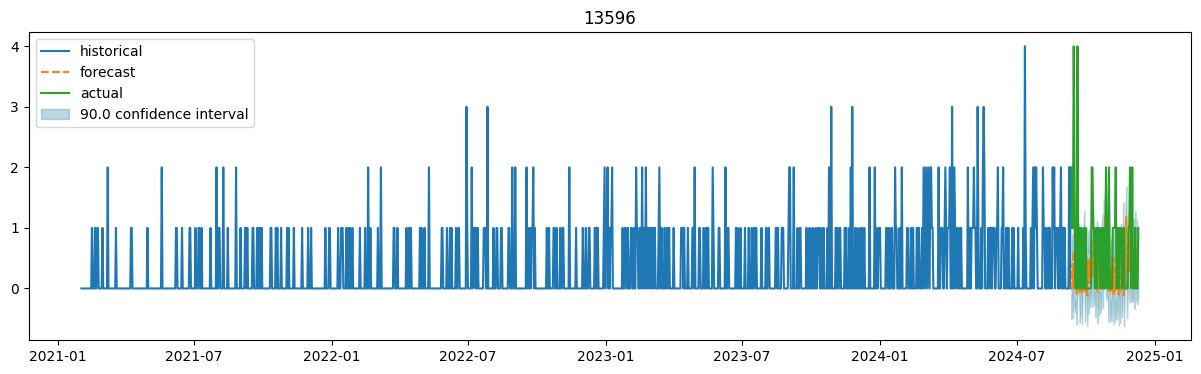

Product_id :  20547


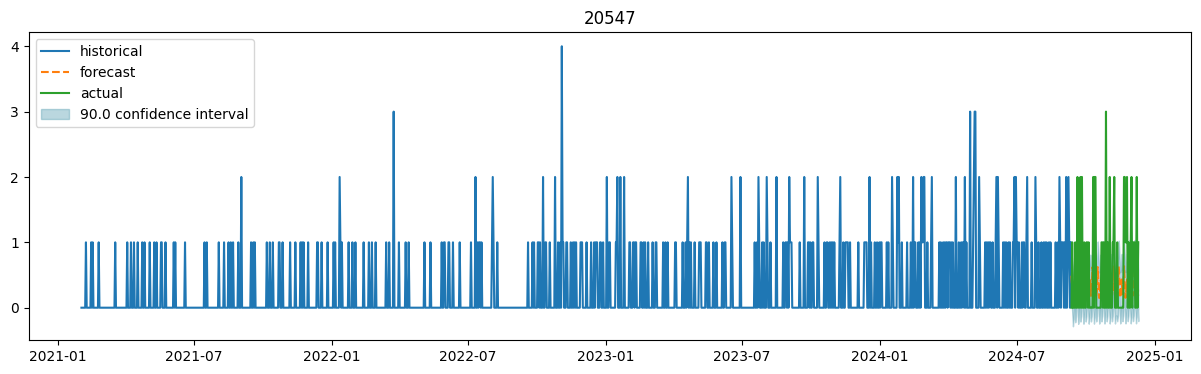

Product_id :  20552


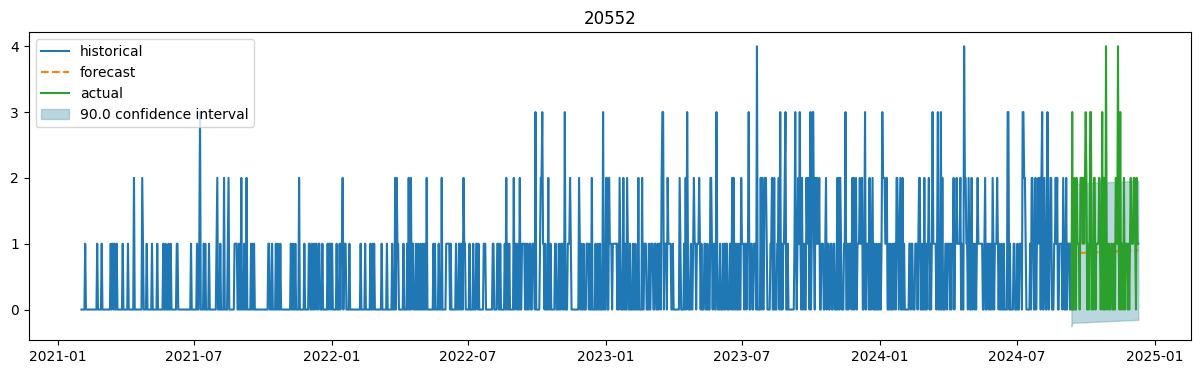

Product_id :  23641


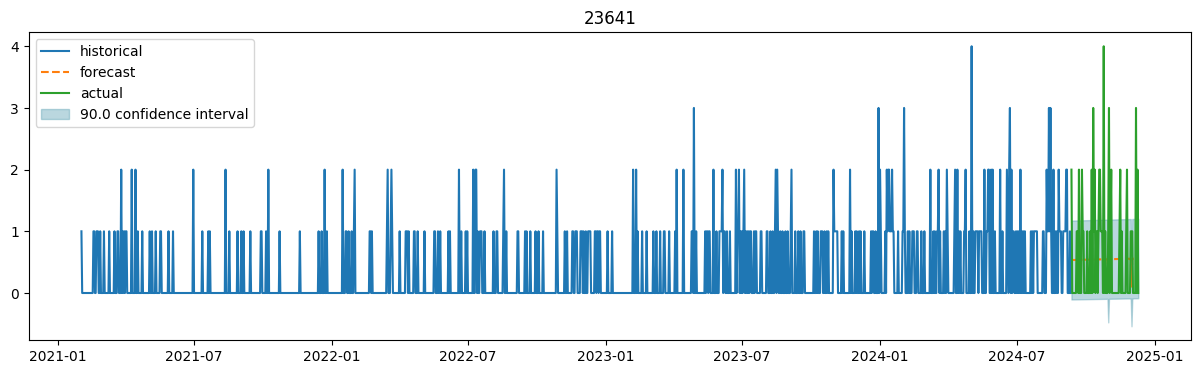

Product_id :  28305


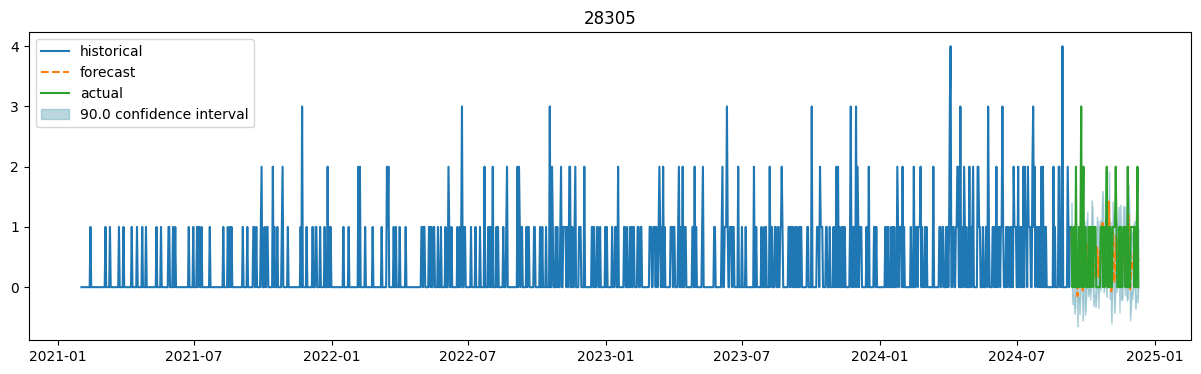

In [87]:
def plot_hist_forecast(
    historical, forecast, actual, hist_start="", hist_end="", title=""
):
    if hist_start != "":
        historical = historical[
            historical["date"] >= pd.to_datetime(hist_start, format="%Y-%m-%d")
        ].copy()
    if hist_end != "":
        historical = historical[
            historical["date"] <= pd.to_datetime(hist_end, format="%Y-%m-%d")
        ].copy()

    plt.figure(figsize=(15, 4))
    plt.plot(historical["date"], historical["sales_count"], label="historical")
    # Plot the forecast data
    plt.plot(
        forecast["forecast_timestamp"],
        forecast["forecast_value"],
        label="forecast",
        linestyle="--",
    )
    # Plot the actual data
    plt.plot(actual["date"], actual["sales_count"], label="actual")
    # plot the confidence interval
    confidence_level = forecast["confidence_level"].iloc[0] * 100
    low_CI = forecast["confidence_interval_lower_bound"]
    upper_CI = forecast["confidence_interval_upper_bound"]

    # Shade the confidence interval
    plt.fill_between(
        forecast["forecast_timestamp"],
        low_CI,
        upper_CI,
        color="#539caf",
        alpha=0.4,
        label=f"{confidence_level} confidence interval",
    )
    plt.legend()
    plt.title(title)
    plt.show()
    return


product_id_list = dfforecast["product_id"].unique()
for i in product_id_list:
    print("Product_id : ", i)
    plot_hist_forecast(
        df_historical[df_historical["product_id"] == i],
        dfforecast[dfforecast["product_id"] == i],
        df_actual_90d[df_actual_90d["product_id"] == i],
        hist_start="2021-02-01",
        title=i,
    )

While most of the predictions are looking decent, you can also see that the actual ranges fall into the 90% confidence interval suggested by the model. Under the hood, BigQuery ML performs many computationally expensive tasks even considering the seasonal and holiday information.
<img src="https://cloud.google.com/bigquery-ml/images/BQ_ARIMA_diagram.png"> <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series"> Source</a> </img>

The coefficients learned by BigQuery ML's ARIMA model can also be checked by querying for <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-arima-coefficients">ARIMA_COEFFICIENTS</a> from the model.

#@bigquery
SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL demandforecasting_unique.arima_plus_model)

In [ ]:
query = """
SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL {dataset_id}.arima_plus_model)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

In [ ]:
query_job.to_dataframe()

In the above results, 
- The <b>product_id</b> column represents the index column that we've specified while training the ARIMA model.
- The <b>ar_coefficients</b> column corresponds to the autoregressive coefficients in the ARIMA algorithm (non-seasonal p).
- <b>ma_coefficients</b> refers to the moving average coefficients in the ARIMA algorithm (non-seasonal q).
- <b>intercept_or_drift</b> is the constant term in the ARIMA algorithm.

## Evaluating the model results using BigQuery ML 

BigQuery ML also provides the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate">ML.EVALUATE</a> function for checking the evaluation metrics of the trained model. For the ARIMA model, you can see the model being evaluated on `log_likelihood`, `AIC` and `variance`. 

#@bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL demandforecasting_unique.arima_plus_model)

In [ ]:
query = """
SELECT
  *
FROM
  ML.EVALUATE(MODEL {dataset_id}.arima_model)
""".format(
    dataset_id=dataset_id
)
query_job = client.query(query)

In [ ]:
query_job.to_dataframe()

## Evaluting the model results - MAE, MAPE, MSE, RMSE (on Test data)

Generally, to evaluate the forecast model, you can choose metrics depending on how you want to evaluate. For starters, you can choose from the following: 
* <b>Mean Absolute Error (MAE)</b>: Average of the absolute differences between the actual values and the forecasted values.
* <b>Mean Absolute Percentage Error (MAPE)</b>: Average of the percentages of absolute difference between the actual and forecasted values to the actual values.
* <b>Mean Squared Error (MSE)</b>: Average of squared differences between the actual and forecasted values.
* <b>Root Mean Squared Error (RMSE)</b>: Root of MSE

In [88]:
df_actual_90d.sort_values(by=["product_id", "date"], inplace=True)
df_actual_90d.reset_index(drop=True, inplace=True)
dfforecast.sort_values(by=["product_id", "forecast_timestamp"], inplace=True)
dfforecast.reset_index(drop=True, inplace=True)

In [89]:
errors = {"product_id": [], "MAE": [], "MAPE": [], "MSE": [], "RMSE": []}
for i in product_id_list:
    mae = mean_absolute_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"],
    )
    mape = mean_absolute_percentage_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"],
    )

    mse = mean_squared_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"],
        #squared=True,
    )

    # rmse = mean_squared_error(
    #     df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
    #     dfforecast[dfforecast["product_id"] == i]["forecast_value"],
    #     squared=False,
    # )
    
    rmse = root_mean_squared_error(
        df_actual_90d[df_actual_90d["product_id"] == i]["sales_count"],
        dfforecast[dfforecast["product_id"] == i]["forecast_value"]
    )

    errors["product_id"].append(i)
    errors["MAE"].append(mae)
    errors["MAPE"].append(mape)
    errors["MSE"].append(mse)
    errors["RMSE"].append(rmse)
errors = pd.DataFrame(errors)
errors

,product_id,MAE,MAPE,MSE,RMSE
0,13596,0.641820,8.393786e+14,0.791518,0.889673
1,20547,0.634386,8.835749e+14,0.668288,0.817489
2,20552,0.767161,1.223523e+15,1.029326,1.014557
3,23641,0.740167,1.450353e+15,0.830148,0.911125
4,28305,0.612848,1.033042e+15,0.547122,0.739677


From the values obtained for these error measures, it looks like product ID 20552's 13,596's error measures are high. Note that these error measures are an aggregate of all the individual forecasts made during the test period and so reflect an overall picture of the model's performance over the selected period. Ideally, the lower these error measures, the better the model is at forecasting.

## Executor feature in managed instances

If you're using managed instances, along the top toolbar, above your notebook, click the **Executor** button.

<img src="images/navbar_exe.png" ></img>


Give the execution a name. Select the **Cloud Storage bucket**, **Machine type**, and **Accelerator type**. For the **Environment**, select **Python 3**.

<img src="images/exe_form.png" style="width:500px"></img>


<img src="images/python3_env_selection.png" style="width:500px"></img>


In the **Type** menu, you can select schedule-based recurring executions if you want to schedule the execution to run on an interval, such as one hour.

<img src="images/schedule.png" style="height:200px;"></img>


You can see the history of your executions by clicking the **Notebook Executor** button, on the left sidebar. It looks like a calendar icon.

<img src="images/side_nav.png" style="height:500px;"></img>


You can see execution history on the **Executions** tab.

<img src="images/list_execution.png" style="width:500px"></img>


You can see your active schedules on the **Schedules** tab.

<img src="images/list_schedule.png" style="width:500px"></img>


## Clean up


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial. The following code deletes the entire dataset.


In [ ]:
# Set dataset variable to the ID of the dataset to fetch.
dataset = f"{PROJECT_ID}.{dataset_id}"

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))

# Delete Cloud Storage objects that were created
delete_bucket = True  # Set True for deletion
if delete_bucket:
    ! gsutil -m rm -r $BUCKET_URI